In [1]:
import pystencils as ps
from lbmpy.session import *
from lbmpy.moments import is_shear_moment, get_order

# Demo: Thermalized (Randomized) LBM

This demo notebook shows how to modify the LB collision operator to account for microscopic fluctuations. This technique is also called thermalized or randomized LBM. In these methods a random fluctuation is added to the equilibrium moments. In this simple example we implement a thermalized model by writing our own simple linear congruent random number generator, the draws indepedent random numbers on each cell. A seed is stored for each cell since all cells are processed in parallel.

## 1) Creating the method definition

We begin with a standard SRT method...

In [2]:
random_number_symbols = sp.symbols("rand_:3")
method = create_lb_method(method='srt', relaxation_rate=1.8)
method

Moment,Eq. Value,Relaxation Rate
$1$,$\rho$,$1.8$
$x$,$u_{0}$,$1.8$
$y$,$u_{1}$,$1.8$
$x^{2}$,$\frac{\rho}{3} + u_{0}^{2}$,$1.8$
$y^{2}$,$\frac{\rho}{3} + u_{1}^{2}$,$1.8$
$x y$,$u_{0} u_{1}$,$1.8$
$x^{2} y$,$\frac{u_{1}}{3}$,$1.8$
$x y^{2}$,$\frac{u_{0}}{3}$,$1.8$
$x^{2} y^{2}$,$\frac{\rho}{9} + \frac{u_{0}^{2}}{3} + \frac{u_{1}^{2}}{3}$,$1.8$


...and modify its collision table. The `create_lb_method_from_existing` function provides a convenient way to do this. 
We pass a custom function that receives a row of the collision table and returns a modified version of it.
Our modification rule adds symbols that stand for random numbers to some of the moments.

In [3]:
def modification_func(moment, equilibrium, relaxation_rate):
    if is_shear_moment(moment, dim=method.dim):
        equilibrium += random_number_symbols[0] * 0.001
    elif get_order(moment) > 2:
        equilibrium += random_number_symbols[1] * 0.001
    return moment, equilibrium, relaxation_rate


thermalized_method = create_lb_method_from_existing(method, modification_func)
thermalized_method.override_weights(method.weights)
thermalized_method

Moment,Eq. Value,Relaxation Rate
$1$,$\rho$,$1.8$
$x$,$u_{0}$,$1.8$
$y$,$u_{1}$,$1.8$
$x^{2}$,$0.001 rand_{0} + \frac{\rho}{3} + u_{0}^{2}$,$1.8$
$y^{2}$,$0.001 rand_{0} + \frac{\rho}{3} + u_{1}^{2}$,$1.8$
$x y$,$0.001 rand_{0} + u_{0} u_{1}$,$1.8$
$x^{2} y$,$0.001 rand_{1} + \frac{u_{1}}{3}$,$1.8$
$x y^{2}$,$0.001 rand_{1} + \frac{u_{0}}{3}$,$1.8$
$x^{2} y^{2}$,$0.001 rand_{1} + \frac{\rho}{9} + \frac{u_{0}^{2}}{3} + \frac{u_{1}^{2}}{3}$,$1.8$


## 2) Creating the kernel equations

Next we have to define rules how to compute the quantities $rand_0$ and $rand_1$. 
We do this using a linear congruent RNG on each cell. We pass in a seed array, and in each time step this seed array is updated with the new random numbers.

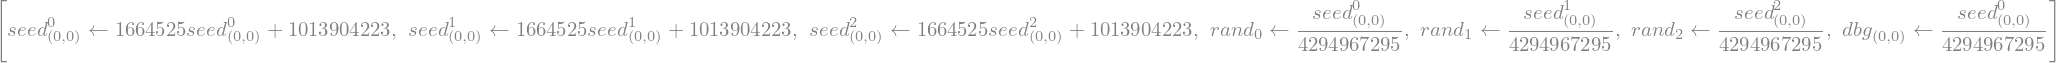

In [4]:
dh = ps.create_data_handling(domain_size=(80, 80))

seed_type = np.uint32
max_seed_type = np.iinfo(seed_type).max

# Initialize the seed array
seedField = dh.add_array('seed', dtype=seed_type, values_per_cell=len(random_number_symbols))
for b in dh.iterate():
    random_field = np.random.randint(0, high=max_seed_type, dtype=seed_type, size=b['seed'].shape)
    np.copyto(b['seed'], random_field)
    
debug_output = dh.add_array('dbg')

linear_congruent_rng_eqs = [ps.Assignment(seedField(i), seedField(i) * 1664525 + 1013904223) 
                            for i, _ in enumerate(random_number_symbols)]
floatEqs = [ps.Assignment(ps.TypedSymbol(s.name, np.float64), seedField(i) / max_seed_type)
            for i, s in enumerate(random_number_symbols)]
                      
rng_eqs = linear_congruent_rng_eqs + floatEqs + [ps.Assignment(debug_output.center, seedField(0) / max_seed_type)]
rng_eqs

These assignments are then added to the LB collision rule.

In [5]:
collision_rule = create_lb_collision_rule(lb_method=thermalized_method)
collision_rule.subexpressions += rng_eqs

Finally, lets test our method by running a lid-driven-cavity with it.

In [6]:
ldc = create_lid_driven_cavity(data_handling=dh, collision_rule=collision_rule, lid_velocity=0.05,
                               kernel_params={'rand_0': 0, 'rand_1': 0})

In [7]:
#show_code(ldc.ast)

In [8]:
ldc.run(100)

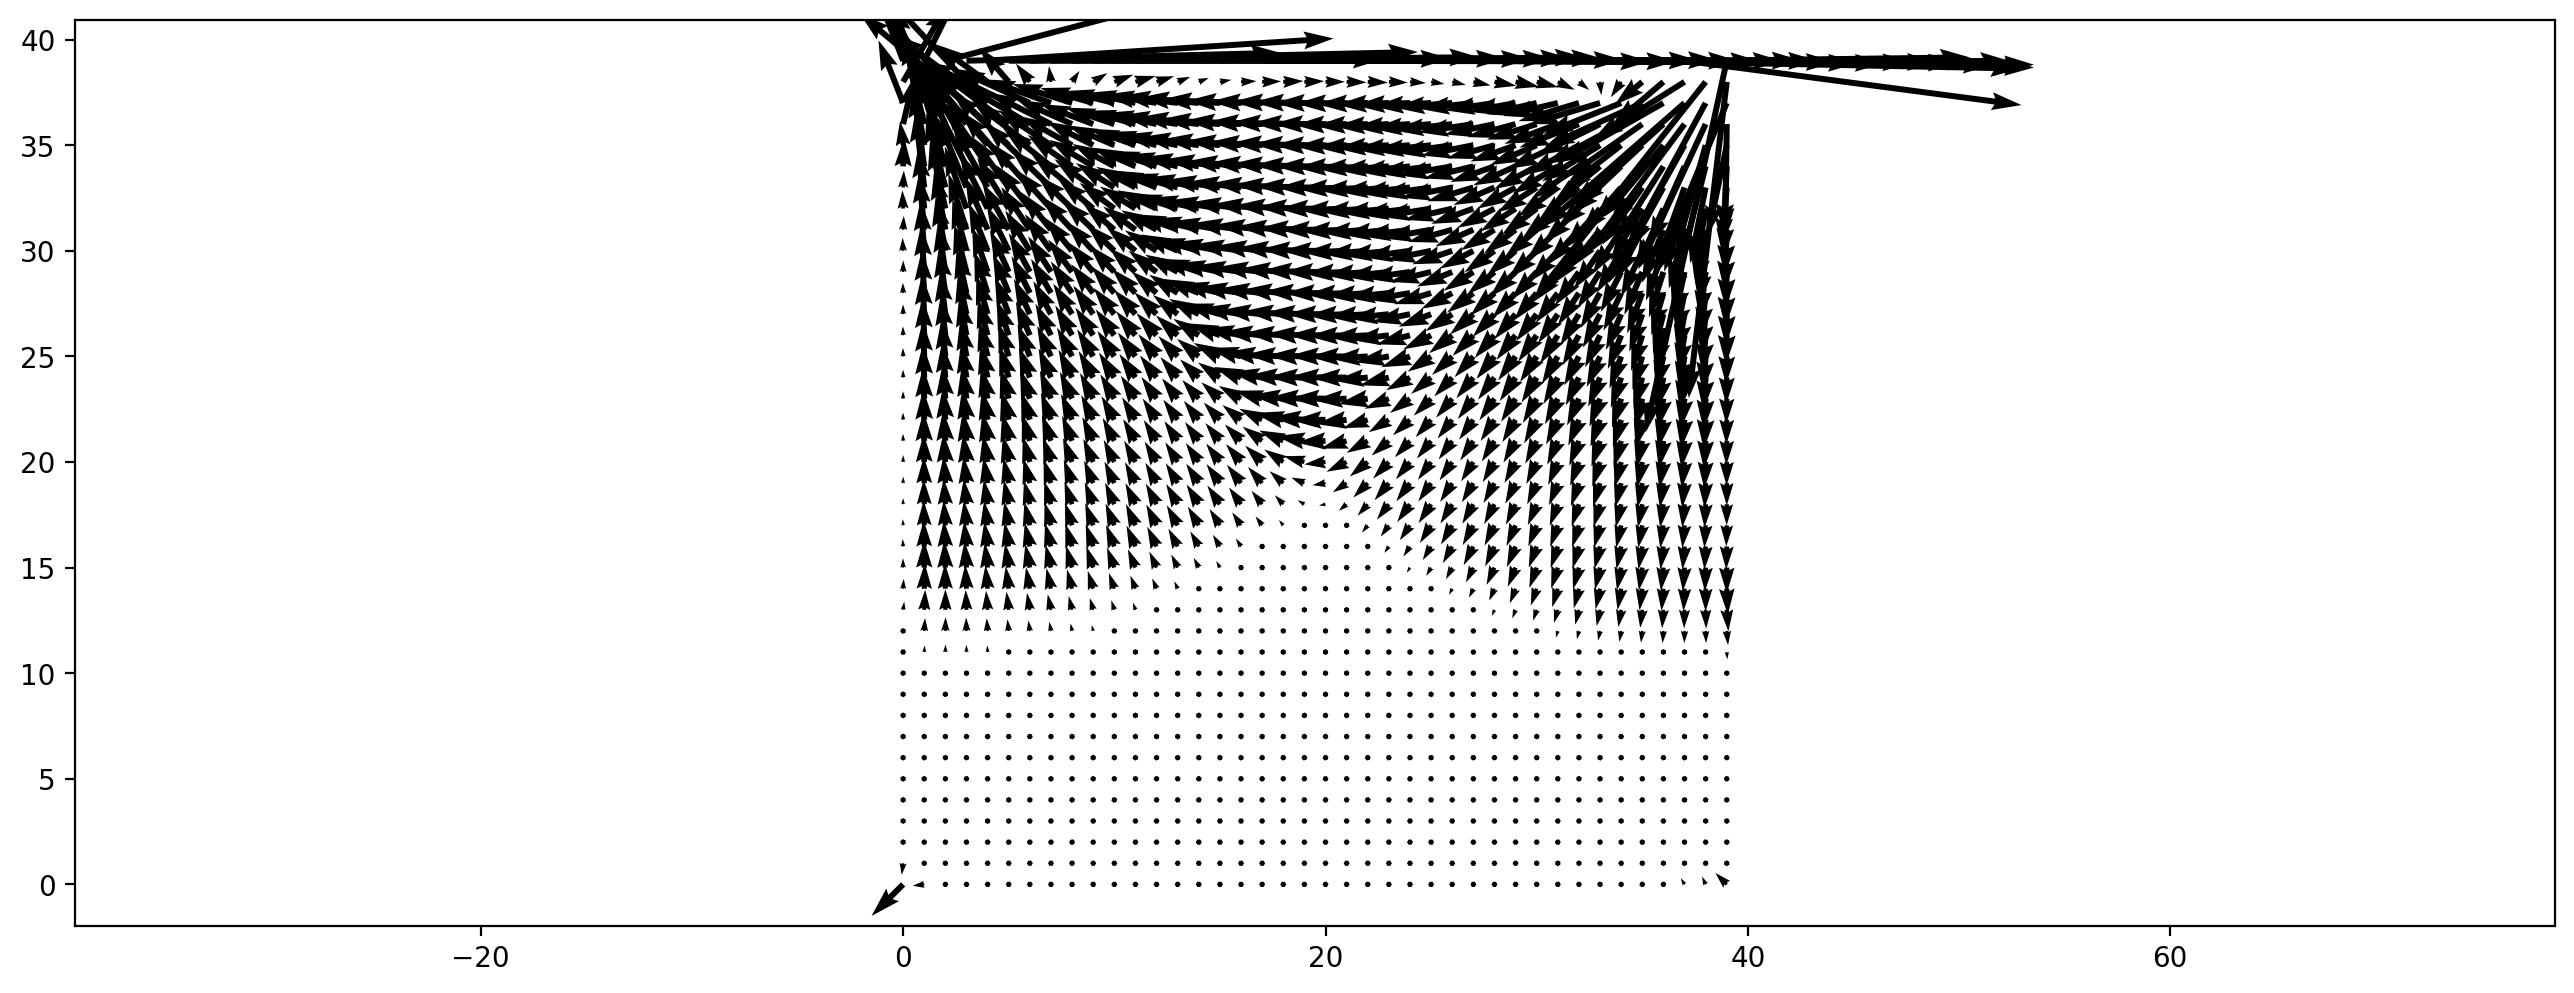

In [9]:
plt.figure(dpi=200)
plt.vector_field(ldc.velocity[:, :]);

In [10]:
assert np.isfinite(dh.max('ldc_velocity'))